# 0. Setup

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import binary_crossentropy
from keras import backend as K 

tf.compat.v1.keras.backend.set_session\
(tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(intra_op_parallelism_threads = 8, inter_op_parallelism_threads=8)))

#tf.compat.v1.keras.backend.set_session\
#(tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement = True, device_count = {'CPU' : 1})))


#config = tf.compat.v1.ConfigProto(allow_soft_placement=True, device_count = {'CPU': 1})
#session = tf.compat.v1.Session(config=config)

# NUM_THREADS = …
# sess = tf.Session(config=tf.ConfigProto(
#     intra_op_parallelism_threads=NUM_THREADS))


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import io
import os
import PIL
import yaml

import boto3
import s3fs



Using TensorFlow backend.


In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print(f"\nNumber of replicas: {strategy.num_replicas_in_sync}\n")

devices = tf.config.experimental.get_visible_devices()
print(f"Devices: {devices}\n")
print(f"{tf.config.experimental.list_logical_devices('GPU')}\n")

print(f"Num CPU Available: {len(tf.config.list_physical_devices('CPU'))}")
print(f"Num GPU Available: {len(tf.config.list_physical_devices('GPU'))}\n")

print(f"All Pysical Devices: {tf.config.list_physical_devices()}")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/datac_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.1.3
keras version 2.3.0-tf
Eager Execution Enabled: True

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Number of replicas: 1

Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

Num CPU Available: 1
Num GPU Available: 1

All Pysical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
len(tf.config.list_physical_devices('CPU'))

1

In [4]:
# you will need to create your own aws credentials to access S3
creds = yaml.safe_load(open('aws_credentials.yml'))
AWS_ACCESS_KEY = creds['aws_access_key_id']
AWS_SECRET_ACCESS_KEY = creds['aws_secret_key_id']
BUCKET_NAME = 'cs205-project-xray'
S3_DIRECTORY = 's3://' + BUCKET_NAME

# 1. Data loading

### 1.1 Configurations and helper functions

In [5]:
HEIGHT = 256
WIDTH = 256
BATCH_SIZE = 32
BUFFER_SIZE = 64

# connect to AWS S3
s3_resource = boto3.resource('s3',
                             aws_access_key_id=AWS_ACCESS_KEY,
                             aws_secret_access_key=AWS_SECRET_ACCESS_KEY)

my_bucket = s3_resource.Bucket(name=BUCKET_NAME)

In [6]:
###
# Helper functions to create data set
# - modified from Ashref Maiza's code in the link below 
# - link: https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72
###

def format_img_and_label(im_file, lab):
    img_dir = S3_DIRECTORY + '/images/' + im_file
    # read in image tensor
    img_str = tf.io.read_file(img_dir)   
    # decode image
    img_decoded = tf.image.decode_png(img_str, channels=3)
    # resize image to fixed shape
    resized_img = tf.image.resize(img_decoded, [HEIGHT, WIDTH])
    # normalize image
    normalized_img = resized_img / 255.0
    return normalized_img, lab

def create_dataset(filenames, labels):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(format_img_and_label)
    return dataset

In [7]:
# fetch image data (unused function)
#def fetch_input(path):     
#  img_object = s3_resource.Object(BUCKET_NAME,path)
#  img = PIL.Image.open(img_object.get()['Body'])
#  return(img)

### 1.2 Load and  create data set

In [8]:
# fetch links to image files from S3
loaded_imgs = []

for image_file in my_bucket.objects.filter(Prefix='images').limit(5000):
  # record which images were downloaded (since this is only a subet of full dataset)
    loaded_imgs.append(image_file.key[7:])
    # make images folder if it doesnt exist already
    #if not os.path.exists(os.path.dirname(image_file.key)):
    #    os.makedirs(os.path.dirname(image_file.key)) 
    # download into local
    #my_bucket.download_file(image_file.key, image_file.key)

In [9]:
# load image labels
df = pd.read_csv('s3://cs205-project-xray/Data_Entry_2017_v2020.csv')
df = df[df['Image Index'].isin(loaded_imgs)]
img_and_label = df[["Image Index", "Finding Labels"]]
img_and_label['Finding Labels'] = img_and_label['Finding Labels'].str.split('|')

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
X_train, X_val, y_train, y_val = train_test_split(img_and_label['Image Index'], 
                                                  img_and_label['Finding Labels'], 
                                                  test_size=0.2)

X_train = list(X_train)
X_val = list(X_val)
y_train = list(y_train)
y_val = list(y_val)

Since we have multi-label classification problem, we must encode our labels as a binary vector (15 by 1 vector)

In [11]:
MLB = MultiLabelBinarizer()
MLB.fit(y_train)

vec2label_dict = {}

# 15 label classes
for (encode_num, label) in enumerate(MLB.classes_):
    vec2label_dict[encode_num] = label
    print(encode_num, label)

0 Atelectasis
1 Cardiomegaly
2 Consolidation
3 Edema
4 Effusion
5 Emphysema
6 Fibrosis
7 Hernia
8 Infiltration
9 Mass
10 No Finding
11 Nodule
12 Pleural_Thickening
13 Pneumonia
14 Pneumothorax


In [12]:
# multi-label binary transform our labels
y_train = MLB.transform(y_train)
y_val = MLB.transform(y_val)

In [13]:
train_data = create_dataset(X_train, y_train)
test_data = create_dataset(X_val, y_val)

for f, l in test_data.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape, '\n')

print(f'Number of images in train set: {tf.data.experimental.cardinality(train_data).numpy()}' )
print(f'Number of images in test set: {tf.data.experimental.cardinality(test_data).numpy()}' )

Shape of features array: (256, 256, 3)
Shape of labels array: (15,) 

Number of images in train set: 4000
Number of images in test set: 1000


Let's take a look at a small batch of the X-ray images:

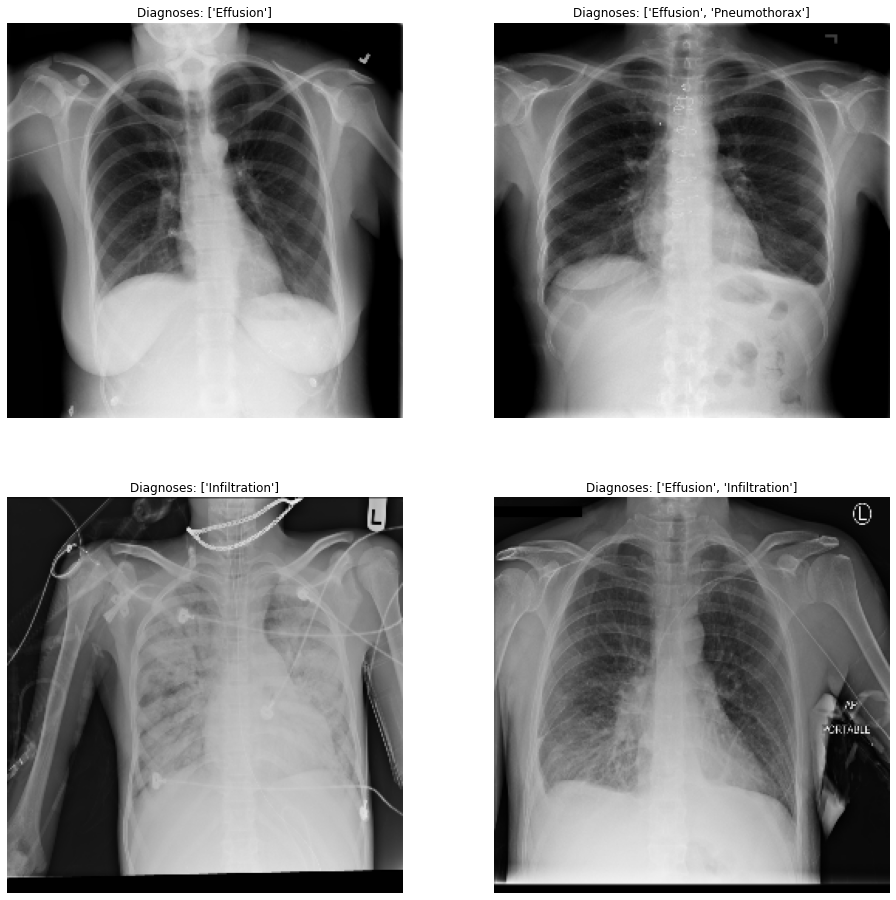

In [14]:
sample_imgs = train_data.take(4)
fig, ax = plt.subplots(2, 2, figsize=(16,16))

# loop over tge four images using numpy iterator
for ax, (img, label) in zip(ax.ravel(), sample_imgs.as_numpy_iterator()):
    # break when no more axes left
    if ax is None:
        break
    indices = [i for i, x in enumerate(label) if x == 1]
    diseases = [vec2label_dict[i] for i in indices]
    ax.imshow(img)
    ax.set_title(f"Diagnoses: {diseases}")
    ax.axis('off')


# 2. Model building and training

We will use MobileNet, and transfer learning to save time on training.

In [15]:
cnn_base = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

cnn_base.summary()


cnn_base.trainable

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 257, 257, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 128, 128, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 128, 128, 32

True

In [16]:
cnn_base.trainable

True

In [17]:
cnn_base.trainable = True
set_trainable = False
for layer in cnn_base.layers:
    layer.trainable = True
    
    """
    if layer.name == 'conv_dw_10':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        print(layer.name)
    else:
        layer.trainable = False
        """

In [18]:
model = tf.keras.models.Sequential([
  cnn_base,
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(64, activation='relu'),
  # 15 labels to classify
  layers.Dense(15, activation='sigmoid')
])

# final number of parameters after adding on head layer to base MobileNet
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 8, 8, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16777472  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                975       
Total params: 20,023,759
Trainable params: 20,001,871
Non-trainable params: 21,888
_______________________________________

In [19]:
model.compile(optimizer=RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
%%time
history = model.fit(train_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE),
                    validation_data=test_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE),
                    epochs=20)

Train for 125 steps, validate for 32 steps
Epoch 1/20
125/125 [==============================] - 438s 4s/step - loss: 0.2479 - accuracy: 0.9172 - val_loss: 0.2111 - val_accuracy: 0.9289
Epoch 2/20
 50/125 [===========>..................] - ETA: 3:25 - loss: 0.1689 - accuracy: 0.9397

KeyboardInterrupt: 